# Deep RL for Blackjack: DQN & Joint Bet+Play Policy

**Theme:** Can a neural network scale beyond tabular RL and learn both *how to play* and *how much to bet*?

### Imports & Config

In [1]:
import random
from collections import deque, defaultdict

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Hi-Lo buckets (cap extremes)
TRUE_COUNT_BUCKETS = list(range(-5, 6))  # [-5, ..., +5]

# Bet options (units)
BET_OPTIONS = [1, 2, 4, 8]
N_BETS = len(BET_OPTIONS)

# Play actions (offset after bet actions)
HIT, STAND, DOUBLE = 0, 1, 2
PLAY_ACTIONS = [HIT, STAND, DOUBLE]
N_PLAY = len(PLAY_ACTIONS)

# Global action space for DQN:
# 0..(N_BETS-1) => choose bet at BET phase
# N_BETS..(N_BETS+N_PLAY-1) => HIT/STAND/DOUBLE at PLAY phase
ACTION_INDEX_HIT     = N_BETS + HIT
ACTION_INDEX_STAND   = N_BETS + STAND
ACTION_INDEX_DOUBLE  = N_BETS + DOUBLE
N_ACTIONS = N_BETS + N_PLAY

# Environment config
N_DECKS = 6
PENETRATION = 0.75          # shuffle after 75% dealt
DEALER_STANDS_SOFT17 = True
BLACKJACK_PAYOUT = 1.5

# DQN hyperparams
EPISODES = 150_000          # adjust up for stronger results
GAMMA = 1.0
LR = 2e-4
BATCH_SIZE = 256
REPLAY_CAPACITY = 200_000
TARGET_UPDATE_EVERY = 2_000
EPS_START = 0.20
EPS_END = 0.02

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

### Deep environment (bet phase + play phase, count-aware)

In [2]:
class DeepCountingBlackjackEnv:
    """
    Blackjack with:
      - n_decks, penetration (reshuffle when remaining <= threshold)
      - Hi–Lo running count and true-count bucket
      - Two phases:
         (1) BET phase: pick a bet (discrete from BET_OPTIONS)
         (2) PLAY phase: Hit/Stand/Double (double only on first decision)
      - Dealer stands on soft 17 (S17) by default
      - Blackjack pays 3:2
    Rewards are only terminal (final hand outcome scaled by bet).
    """

    def __init__(self,
                 n_decks=N_DECKS,
                 penetration=PENETRATION,
                 dealer_stands_soft17=DEALER_STANDS_SOFT17,
                 blackjack_payout=BLACKJACK_PAYOUT):
        self.n_decks = n_decks
        self.penetration = penetration
        self.dealer_stands_soft17 = dealer_stands_soft17
        self.blackjack_payout = blackjack_payout

        self.initial_shoe_size = 52 * self.n_decks
        self.reshuffle_threshold = int(self.initial_shoe_size * (1.0 - self.penetration))
        self._init_shoe()

        # hand state
        self.player = []
        self.dealer = []
        self.allow_double = True

        # phase / bet
        self.in_bet_phase = True
        self.bet_units = 0

    # ---------- shoe & count ----------
    def _init_shoe(self):
        one_deck = [1,2,3,4,5,6,7,8,9,10,10,10,10] * 4
        self.shoe = one_deck * self.n_decks
        random.shuffle(self.shoe)
        self.running_count = 0

    @staticmethod
    def _count_card(card):
        if 2 <= card <= 6:
            return +1
        if card == 1 or card == 10:
            return -1
        return 0

    def _draw(self):
        if len(self.shoe) <= self.reshuffle_threshold:
            self._init_shoe()
        card = self.shoe.pop()
        self.running_count += self._count_card(card)
        return card

    def true_count(self):
        decks_rem = max(1e-6, len(self.shoe) / 52.0)
        tc = self.running_count / decks_rem
        bucket = int(max(min(tc, TRUE_COUNT_BUCKETS[-1]), TRUE_COUNT_BUCKETS[0]))
        return tc, bucket

    # ---------- hand utils ----------
    @staticmethod
    def _hand_value(cards):
        total = sum(cards)
        usable = 1 in cards and total + 10 <= 21
        return (total + 10, True) if usable else (total, False)

    @staticmethod
    def _is_blackjack(cards):
        return len(cards) == 2 and 1 in cards and sum(cards) + 10 == 21

    # ---------- observation vector ----------
    def _obs_vector(self):
        """
        Return a fixed-size numeric vector for DQN:
         [phase_play,               # 1 if play-phase, 0 if bet-phase
          player_total_norm,        # /21 (0 if bet phase)
          dealer_up_norm,           # /10 (0 if bet phase)
          usable_ace,               # 0/1
          allow_double,             # 0/1
          true_count_bucket_norm,   # bucket / max(|min|,|max|)
          bet_norm]                 # current bet / max(BET_OPTIONS)
        """
        phase_play = 0.0 if self.in_bet_phase else 1.0
        tc, bucket = self.true_count()
        bucket_norm = bucket / max(abs(TRUE_COUNT_BUCKETS[0]), TRUE_COUNT_BUCKETS[-1])
        bet_norm = self.bet_units / max(BET_OPTIONS)

        if self.in_bet_phase:
            player_total_norm = 0.0
            dealer_up_norm = 0.0
            usable = 0.0
            allow_double = 0.0
        else:
            pt, usable_ace = self._hand_value(self.player)
            player_total_norm = pt / 21.0
            dealer_up_norm = self.dealer[0] / 10.0
            usable = 1.0 if usable_ace else 0.0
            allow_double = 1.0 if self.allow_double else 0.0

        return np.array([
            phase_play,
            player_total_norm,
            dealer_up_norm,
            usable,
            allow_double,
            bucket_norm,
            bet_norm
        ], dtype=np.float32)

    # ---------- valid actions ----------
    def valid_action_indices(self):
        if self.in_bet_phase:
            return list(range(N_BETS))
        # play phase
        inds = [ACTION_INDEX_HIT, ACTION_INDEX_STAND]
        if self.allow_double:
            inds.append(ACTION_INDEX_DOUBLE)
        return inds

    # ---------- API ----------
    def reset(self):
        if len(self.shoe) <= self.reshuffle_threshold:
            self._init_shoe()
        self.in_bet_phase = True
        self.bet_units = 0
        self.player = []
        self.dealer = []
        self.allow_double = True
        return self._obs_vector()

    def step(self, action_index):
        """
        Returns: next_obs_vec, reward, done, info
        Rewards are terminal only; intermediate steps give 0.
        """
        # BET PHASE
        if self.in_bet_phase:
            # Must choose a bet action
            if not (0 <= action_index < N_BETS):
                # invalid -> map to smallest bet
                action_index = 0
            self.bet_units = BET_OPTIONS[action_index]
            # deal initial cards
            self.player = [self._draw(), self._draw()]
            self.dealer = [self._draw(), self._draw()]
            self.allow_double = True
            self.in_bet_phase = False

            # naturals resolve immediately
            player_bj = self._is_blackjack(self.player)
            dealer_bj = self._is_blackjack(self.dealer)
            if player_bj or dealer_bj:
                if player_bj and dealer_bj:
                    reward = 0.0
                elif player_bj:
                    reward = self.bet_units * BLACKJACK_PAYOUT
                else:
                    reward = -self.bet_units
                return self._obs_vector(), reward, True, {"natural": True}

            return self._obs_vector(), 0.0, False, {}

        # PLAY PHASE
        # Map global action indices to play actions
        if action_index == ACTION_INDEX_HIT:
            self.player.append(self._draw())
            self.allow_double = False
            pt, _ = self._hand_value(self.player)
            if pt > 21:
                return self._obs_vector(), -self.bet_units, True, {"bust": True}
            return self._obs_vector(), 0.0, False, {}

        elif action_index == ACTION_INDEX_STAND:
            self.allow_double = False
            # dealer plays out
            while True:
                dt, du = self._hand_value(self.dealer)
                if dt < 17:
                    self.dealer.append(self._draw())
                    continue
                if dt == 17 and du and not DEALER_STANDS_SOFT17:
                    self.dealer.append(self._draw())
                    continue
                break
            pt, _ = self._hand_value(self.player)
            dt, _ = self._hand_value(self.dealer)
            if pt > 21:
                base = -1
            elif dt > 21:
                base = +1
            elif pt > dt:
                base = +1
            elif pt < dt:
                base = -1
            else:
                base = 0
            return self._obs_vector(), base * self.bet_units, True, {}

        elif action_index == ACTION_INDEX_DOUBLE:
            if not self.allow_double:
                # treat as hit fallback
                return self.step(ACTION_INDEX_HIT)
            self.player.append(self._draw())
            self.allow_double = False
            pt, _ = self._hand_value(self.player)
            if pt > 21:
                return self._obs_vector(), -2 * self.bet_units, True, {"double_bust": True}
            # dealer plays
            while True:
                dt, du = self._hand_value(self.dealer)
                if dt < 17:
                    self.dealer.append(self._draw())
                    continue
                if dt == 17 and du and not DEALER_STANDS_SOFT17:
                    self.dealer.append(self._draw())
                    continue
                break
            pt, _ = self._hand_value(self.player)
            dt, _ = self._hand_value(self.dealer)
            if pt > 21:
                base = -1
            elif dt > 21:
                base = +1
            elif pt > dt:
                base = +1
            elif pt < dt:
                base = -1
            else:
                base = 0
            return self._obs_vector(), 2 * base * self.bet_units, True, {"doubled": True}

        # Fallback: do nothing (shouldn’t happen)
        return self._obs_vector(), 0.0, False, {}

### DQN network, mask-aware action selection, replay buffer

In [3]:
class QNet(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions),
        )

    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity=REPLAY_CAPACITY):
        self.buf = deque(maxlen=capacity)

    def push(self, s, a, r, s2, done, mask_valid_next):
        # store raw numpy arrays (we’ll torch.tensor() at sample time)
        self.buf.append((s, a, r, s2, done, mask_valid_next))

    def sample(self, batch_size=BATCH_SIZE):
        idx = np.random.choice(len(self.buf), size=batch_size, replace=False)
        batch = [self.buf[i] for i in idx]
        s, a, r, s2, d, mask = zip(*batch)
        return (
            np.vstack(s).astype(np.float32),
            np.array(a, dtype=np.int64),
            np.array(r, dtype=np.float32),
            np.vstack(s2).astype(np.float32),
            np.array(d, dtype=np.float32),
            np.vstack(mask).astype(np.float32),
        )

    def __len__(self):
        return len(self.buf)

def valid_action_mask(env):
    """Return a 1/0 mask over global actions for the CURRENT env state."""
    mask = np.zeros(N_ACTIONS, dtype=np.float32)
    for i in env.valid_action_indices():
        mask[i] = 1.0
    return mask

def masked_argmax(q_values, mask):
    """Return argmax over actions allowed by mask (numpy / torch supported)."""
    # Set invalid actions to very low
    masked = q_values.clone()
    masked[mask == 0] = -1e9
    return torch.argmax(masked).item()

def epsilon_greedy_action(qnet, state_vec, mask, epsilon):
    if np.random.rand() < epsilon:
        valid = np.where(mask > 0)[0]
        return int(np.random.choice(valid))
    with torch.no_grad():
        q = qnet(torch.from_numpy(state_vec).unsqueeze(0).to(DEVICE))
        m = torch.from_numpy(mask).to(DEVICE).unsqueeze(0)
        q[~(m.bool())] = -1e9
        return int(torch.argmax(q, dim=1).item())

### Train DQN

In [4]:
env = DeepCountingBlackjackEnv()

obs_dim = env._obs_vector().shape[0]
qnet = QNet(obs_dim, N_ACTIONS).to(DEVICE)
tgt = QNet(obs_dim, N_ACTIONS).to(DEVICE)
tgt.load_state_dict(qnet.state_dict())
optimizer = optim.Adam(qnet.parameters(), lr=LR)
replay = ReplayBuffer()

epsilon = EPS_START
losses = []
ev_tracker = []

def compute_td_target(q_next, mask_next, rewards, dones):
    """
    q_next: [B, A], mask_next: [B, A]
    target = r + gamma * max_a' q_next(s', a' allowed) * (1-done)
    """
    # set invalid actions to -inf so max ignores them
    q_next_masked = q_next.clone()
    q_next_masked[mask_next == 0] = -1e9
    max_next, _ = q_next_masked.max(dim=1)
    return rewards + (1.0 - dones) * GAMMA * max_next

def evaluate_greedy(env, qnet, n=5000):
    """Estimate EV using greedy policy."""
    total = 0.0
    wins = pushes = losses = 0
    for _ in range(n):
        s = env.reset()
        done = False
        while not done:
            mask = valid_action_mask(env)
            with torch.no_grad():
                q = qnet(torch.from_numpy(s).unsqueeze(0).to(DEVICE))
                m = torch.from_numpy(mask).to(DEVICE).unsqueeze(0)
                q[~(m.bool())] = -1e9
                a = int(torch.argmax(q, dim=1).item())
            s2, r, done, info = env.step(a)
            s = s2
            if done:
                total += r
                if r > 0: wins += 1
                elif r == 0: pushes += 1
                else: losses += 1
                break
    return total / n, wins / n, pushes / n, losses / n

# Warmup with random to seed replay
for _ in range(2000):
    s = env.reset()
    done = False
    while not done:
        mask = valid_action_mask(env)
        a = int(np.random.choice(np.where(mask > 0)[0]))
        s2, r, done, _ = env.step(a)
        # next-state mask
        mask_next = valid_action_mask(env)
        replay.push(s, a, r, s2, float(done), mask_next)
        s = s2

update_count = 0

for ep in range(1, EPISODES + 1):
    # Epsilon linear decay
    epsilon = max(EPS_END, EPS_START * (1 - ep / EPISODES))

    s = env.reset()
    done = False
    while not done:
        mask = valid_action_mask(env)
        a = epsilon_greedy_action(qnet, s, mask, epsilon)
        s2, r, done, _ = env.step(a)
        mask_next = valid_action_mask(env)

        replay.push(s, a, r, s2, float(done), mask_next)
        s = s2

        # Learn
        if len(replay) >= BATCH_SIZE:
            S, A, R, S2, D, M2 = replay.sample(BATCH_SIZE)
            S = torch.from_numpy(S).to(DEVICE)
            A = torch.from_numpy(A).to(DEVICE)
            R = torch.from_numpy(R).to(DEVICE)
            S2 = torch.from_numpy(S2).to(DEVICE)
            D = torch.from_numpy(D).to(DEVICE)
            M2 = torch.from_numpy(M2).to(DEVICE)

            q = qnet(S)                        # [B, A]
            q_a = q.gather(1, A.unsqueeze(1)).squeeze(1)

            with torch.no_grad():
                qn = tgt(S2)                   # target net
                target = compute_td_target(qn, M2, R, D)

            loss = nn.SmoothL1Loss()(q_a, target)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(qnet.parameters(), 5.0)
            optimizer.step()
            losses.append(loss.item())
            update_count += 1

            if update_count % TARGET_UPDATE_EVERY == 0:
                tgt.load_state_dict(qnet.state_dict())

    # Light eval every N episodes (adjust cadence as you like)
    if ep % 5000 == 0:
        ev, w, p, l = evaluate_greedy(DeepCountingBlackjackEnv(), qnet, n=3000)
        ev_tracker.append((ep, ev))
        print(f"Ep {ep:>6} | EV {ev:+.4f} | W/P/L {w:.3f}/{p:.3f}/{l:.3f} | ε={epsilon:.3f}")

print("Training done.")

Ep   5000 | EV -0.0068 | W/P/L 0.438/0.092/0.470 | ε=0.193
Ep  10000 | EV -0.0427 | W/P/L 0.429/0.081/0.490 | ε=0.187
Ep  15000 | EV -0.0392 | W/P/L 0.428/0.081/0.491 | ε=0.180
Ep  20000 | EV -0.0263 | W/P/L 0.433/0.080/0.488 | ε=0.173
Ep  25000 | EV -0.0418 | W/P/L 0.422/0.089/0.489 | ε=0.167
Ep  30000 | EV -0.0342 | W/P/L 0.425/0.088/0.486 | ε=0.160
Ep  35000 | EV -0.0378 | W/P/L 0.423/0.085/0.493 | ε=0.153
Ep  40000 | EV -0.0727 | W/P/L 0.404/0.096/0.500 | ε=0.147
Ep  45000 | EV -0.0287 | W/P/L 0.424/0.094/0.482 | ε=0.140
Ep  50000 | EV -0.0228 | W/P/L 0.428/0.092/0.480 | ε=0.133
Ep  55000 | EV -0.0085 | W/P/L 0.435/0.091/0.474 | ε=0.127
Ep  60000 | EV -0.0540 | W/P/L 0.415/0.094/0.491 | ε=0.120
Ep  65000 | EV -0.0547 | W/P/L 0.415/0.089/0.497 | ε=0.113
Ep  70000 | EV -0.0610 | W/P/L 0.407/0.097/0.496 | ε=0.107
Ep  75000 | EV -0.0165 | W/P/L 0.438/0.085/0.476 | ε=0.100
Ep  80000 | EV -0.0098 | W/P/L 0.443/0.079/0.478 | ε=0.093
Ep  85000 | EV -0.0095 | W/P/L 0.433/0.093/0.474 | ε=0.0

### Plot training loss & EV trend

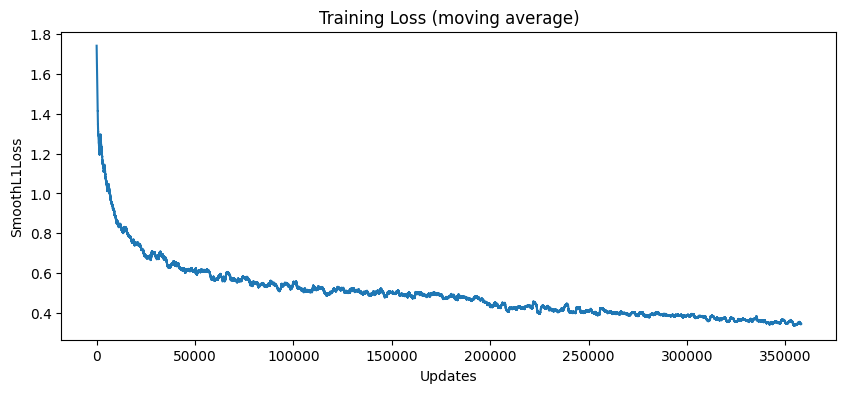

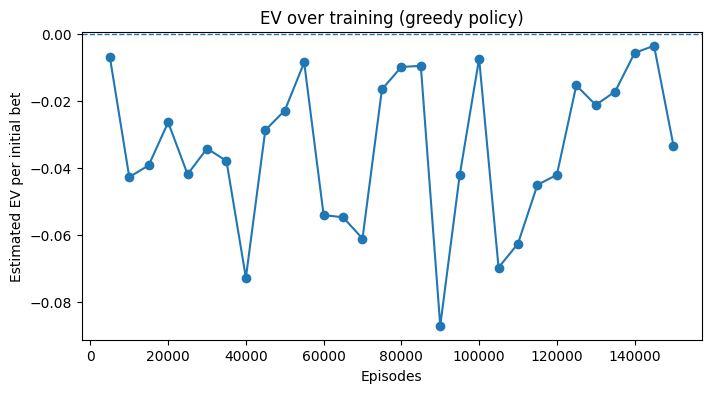

In [5]:
# Loss curve (moving average)
if len(losses) > 0:
    window = 500
    ma = np.convolve(losses, np.ones(window)/window, mode='valid')
    plt.figure(figsize=(10,4))
    plt.plot(ma)
    plt.title("Training Loss (moving average)")
    plt.xlabel("Updates")
    plt.ylabel("SmoothL1Loss")
    plt.show()

# EV checkpoints
if len(ev_tracker) > 0:
    xs, ys = zip(*ev_tracker)
    plt.figure(figsize=(8,4))
    plt.plot(xs, ys, marker='o')
    plt.title("EV over training (greedy policy)")
    plt.xlabel("Episodes")
    plt.ylabel("Estimated EV per initial bet")
    plt.axhline(0, linestyle='--', linewidth=1)
    plt.show()

### Final evaluation (EV + win/push/loss) and betting by count

Final EV: -0.0411 (-4.11%)
Win/Push/Loss: 0.421 / 0.085 / 0.494


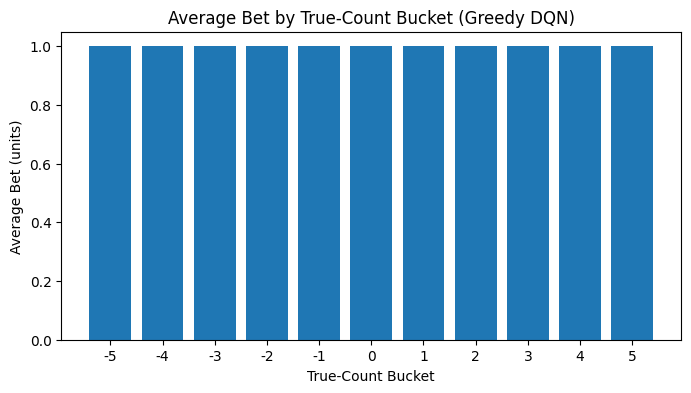

In [6]:
def run_eval(env, qnet, n=20_000):
    total = 0.0
    wins = pushes = losses = 0
    bet_by_bucket = defaultdict(list)

    for _ in range(n):
        s = env.reset()
        done = False
        bet_bucket_captured = None
        chosen_bet_units = None

        while not done:
            mask = valid_action_mask(env)
            with torch.no_grad():
                q = qnet(torch.from_numpy(s).unsqueeze(0).to(DEVICE))
                m = torch.from_numpy(mask).to(DEVICE).unsqueeze(0)
                q[~(m.bool())] = -1e9
                a = int(torch.argmax(q, dim=1).item())

            # If we're in bet phase, record bucket & chosen bet
            if env.in_bet_phase and 0 <= a < N_BETS:
                # current bucket is encoded in state too; but read from env for clarity
                _, bucket = env.true_count()
                bet_bucket_captured = bucket
                chosen_bet_units = BET_OPTIONS[a]

            s2, r, done, _ = env.step(a)
            s = s2
            if done:
                total += r
                if r > 0: wins += 1
                elif r == 0: pushes += 1
                else: losses += 1
                if bet_bucket_captured is not None:
                    bet_by_bucket[bet_bucket_captured].append(chosen_bet_units)
                break

    ev = total / n
    return ev, wins/n, pushes/n, losses/n, bet_by_bucket

ev, w, p, l, bets_by_bucket = run_eval(DeepCountingBlackjackEnv(), qnet, n=20_000)
print(f"Final EV: {ev:+.4f} ({ev*100:+.2f}%)")
print(f"Win/Push/Loss: {w:.3f} / {p:.3f} / {l:.3f}")

# Average bet per true-count bucket
bucket_avgs = []
for b in TRUE_COUNT_BUCKETS:
    vals = bets_by_bucket.get(b, [])
    bucket_avgs.append(np.mean(vals) if len(vals)>0 else 0.0)

plt.figure(figsize=(8,4))
plt.bar([str(b) for b in TRUE_COUNT_BUCKETS], bucket_avgs)
plt.title("Average Bet by True-Count Bucket (Greedy DQN)")
plt.xlabel("True-Count Bucket")
plt.ylabel("Average Bet (units)")
plt.show()

### Peek at learned first decision play chart (bucket = 0 and +3)

In [7]:
ACTION_TO_LETTER = {ACTION_INDEX_HIT: "H", ACTION_INDEX_STAND: "S", ACTION_INDEX_DOUBLE: "D"}

def summarize_first_decision_table(qnet, bucket=0, usable_ace=False):
    """
    Produce a simple table for the FIRST PLAY DECISION (after bet),
    assuming allow_double=True, a chosen bet already made, and given usable_ace flag & bucket.
    """
    lines = ["       " + " ".join([str(d) for d in range(1, 11)])]
    for total in range(12, 22):
        row = []
        for dealer in range(1, 11):
            # Build a synthetic state vector: play-phase
            phase_play = 1.0
            player_total_norm = total / 21.0
            dealer_up_norm = dealer / 10.0
            usable = 1.0 if usable_ace else 0.0
            allow_double = 1.0
            bucket_norm = bucket / max(abs(TRUE_COUNT_BUCKETS[0]), TRUE_COUNT_BUCKETS[-1])
            bet_norm = 1.0 / max(BET_OPTIONS)  # pretend we bet 1 unit; irrelevant for action choice

            s = np.array([phase_play, player_total_norm, dealer_up_norm,
                          usable, allow_double, bucket_norm, bet_norm], dtype=np.float32)

            mask = np.zeros(N_ACTIONS, dtype=np.float32)
            mask[[ACTION_INDEX_HIT, ACTION_INDEX_STAND, ACTION_INDEX_DOUBLE]] = 1.0

            with torch.no_grad():
                q = qnet(torch.from_numpy(s).unsqueeze(0).to(DEVICE))
                m = torch.from_numpy(mask).to(DEVICE).unsqueeze(0)
                q[~(m.bool())] = -1e9
                a = int(torch.argmax(q, dim=1).item())
            row.append(ACTION_TO_LETTER.get(a, "?"))
        lines.append(f"{'Soft' if usable_ace else 'Hard'} {total}: " + " ".join(row))
    return "\n".join(lines)

print("=== First Decision Table (bucket=0, no usable ace) ===")
print(summarize_first_decision_table(qnet, bucket=0, usable_ace=False))
print("\n=== First Decision Table (bucket=0, usable ace) ===")
print(summarize_first_decision_table(qnet, bucket=0, usable_ace=True))

print("\n=== First Decision Table (bucket=+3, no usable ace) ===")
print(summarize_first_decision_table(qnet, bucket=+3, usable_ace=False))
print("\n=== First Decision Table (bucket=+3, usable ace) ===")
print(summarize_first_decision_table(qnet, bucket=+3, usable_ace=True))

=== First Decision Table (bucket=0, no usable ace) ===
       1 2 3 4 5 6 7 8 9 10
Hard 12: H D D D D D D H H H
Hard 13: H H S S H H H H H H
Hard 14: H H H S S S H H H H
Hard 15: H H S S S S S H H H
Hard 16: H H S S S S H H H H
Hard 17: S S S S S S S S S S
Hard 18: S S S S S S S S S S
Hard 19: S S S S S S S S S S
Hard 20: S S S S S S S S S S
Hard 21: S S S S S S S S S S

=== First Decision Table (bucket=0, usable ace) ===
       1 2 3 4 5 6 7 8 9 10
Soft 12: H H H H H H H H H H
Soft 13: H H H H H H H H H H
Soft 14: H H H H H H H H H H
Soft 15: H H H D D D H H H H
Soft 16: H H D D D D D H H H
Soft 17: H D D D D D D D H H
Soft 18: S D D D D D D D D H
Soft 19: S D D D D D D D S S
Soft 20: S D D D D D D D S S
Soft 21: S D D D D D D D S S

=== First Decision Table (bucket=+3, no usable ace) ===
       1 2 3 4 5 6 7 8 9 10
Hard 12: H H H D D D H H H H
Hard 13: H H H H H H H H H H
Hard 14: H H H H H H H H H H
Hard 15: H H S S S S S S H H
Hard 16: H S S S S S S H H H
Hard 17: S S S S S S S S S